In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
from sklearn.model_selection import train_test_split 
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from catboost import CatBoostRegressor,CatBoostClassifier, Pool
from sklearn.model_selection import GridSearchCV
from lightgbm import LGBMClassifier
from sklearn.metrics import roc_curve, auc

import warnings
warnings.filterwarnings(action='ignore')

 - enrollee_id : Unique ID for candidate
 - city: City code
 - city_development_index : Developement index of the city (scaled)
 - gender: Gender of candidate
 - relevent_experience: Relevant experience of candidate 
 - enrolled_university: Type of University course enrolled if any
 - education_level: Education level of candidate
 - major_discipline :Education major discipline of candidate
 - experience: Candidate total experience in years
 - company_size: No of employees in current employer's company
 - company_type : Type of current employer
 - lastnewjob: Difference in years between previous job and current job
 - training_hours: training hours completed
 - target: 0 – Not looking for job change, 1 – Looking for a job change

In [2]:
test = pd.read_csv('C:/KaggleData/HR-Analytics-Job-Change-of-Data-Scientists/aug_test.csv')
train = pd.read_csv('C:/KaggleData/HR-Analytics-Job-Change-of-Data-Scientists/aug_train.csv')

In [8]:
print("="*20, "test","="*20)
display(test.info())
print("="*20, "train","="*20)
display(train.info())


==================== test ====================
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2129 entries, 0 to 2128
Data columns (total 13 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   enrollee_id             2129 non-null   int64  
 1   city                    2129 non-null   object 
 2   city_development_index  2129 non-null   float64
 3   gender                  1621 non-null   object 
 4   relevent_experience     2129 non-null   object 
 5   enrolled_university     2098 non-null   object 
 6   education_level         2077 non-null   object 
 7   major_discipline        1817 non-null   object 
 8   experience              2124 non-null   object 
 9   company_size            1507 non-null   object 
 10  company_type            1495 non-null   object 
 11  last_new_job            2089 non-null   object 
 12  training_hours          2129 non-null   int64  
dtypes: float64(1), int64(2), object(10)
memory usa

None

==================== train ====================
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19158 entries, 0 to 19157
Data columns (total 14 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   enrollee_id             19158 non-null  int64  
 1   city                    19158 non-null  object 
 2   city_development_index  19158 non-null  float64
 3   gender                  14650 non-null  object 
 4   relevent_experience     19158 non-null  object 
 5   enrolled_university     18772 non-null  object 
 6   education_level         18698 non-null  object 
 7   major_discipline        16345 non-null  object 
 8   experience              19093 non-null  object 
 9   company_size            13220 non-null  object 
 10  company_type            13018 non-null  object 
 11  last_new_job            18735 non-null  object 
 12  training_hours          19158 non-null  int64  
 13  target                  19158 non-null  flo

None

## Train Dataset 

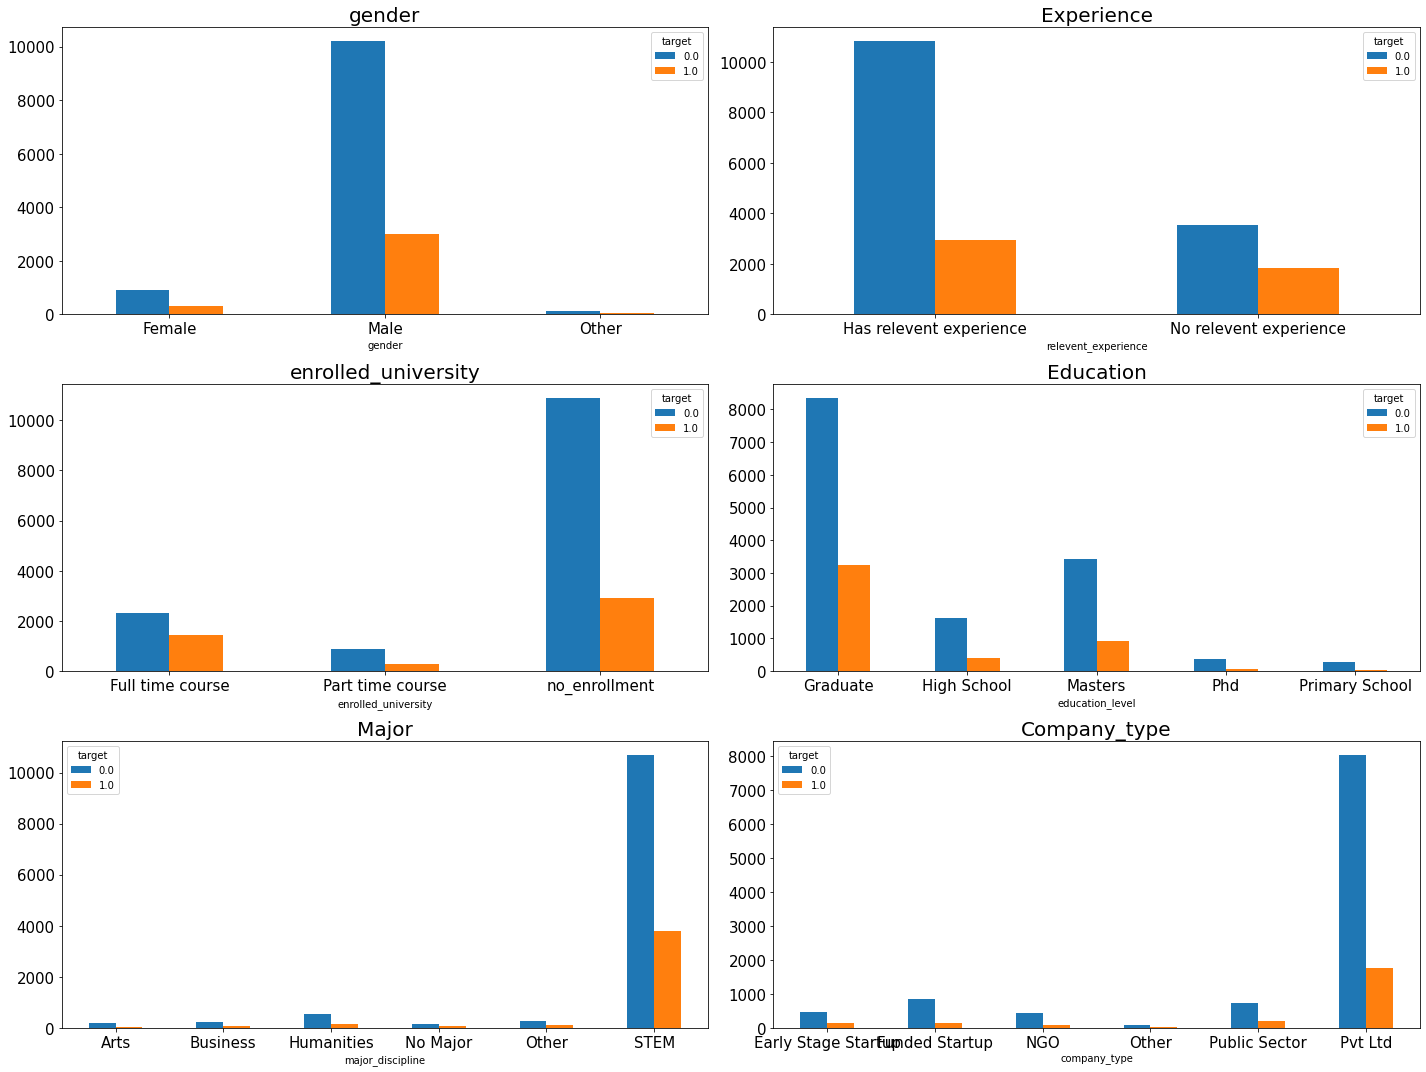

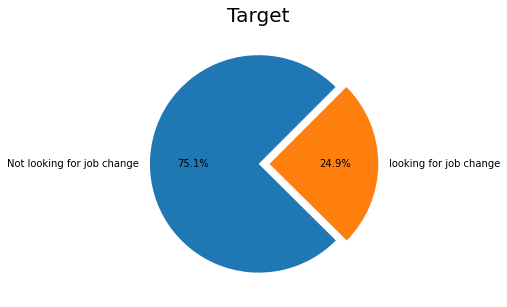

In [10]:
##데이터 시각화
train.major_discipline = train.major_discipline.replace('Business Degree','Business')
fig, ((ax1, ax2), (ax3,ax4),(ax5,ax6)) = plt.subplots(nrows=3, ncols=2)
plt.rcParams['figure.figsize'] = [20,15] 

gender = pd.crosstab(train['gender'],train['target'])
gender.plot(kind='bar',rot=0,ax=ax1,fontsize=15)
ax1.set_title("gender",fontsize=20)


Experience = pd.crosstab(train['relevent_experience'],train['target'])
Experience.plot(kind='bar',rot=0,ax=ax2,fontsize=15)
ax2.set_title("Experience",fontsize=20)


enrolled = pd.crosstab(train['enrolled_university'],train['target'])
enrolled.plot(kind='bar',rot=0,ax=ax3,fontsize=15)
ax3.set_title("enrolled_university",fontsize=20)

education = pd.crosstab(train['education_level'],train['target'])
education.plot(kind='bar',rot=0,ax=ax4,fontsize=15)
ax4.set_title("Education",fontsize=20)

major = pd.crosstab(train['major_discipline'],train['target'])
major.plot(kind='bar',rot=0,ax=ax5,fontsize=15)
ax5.set_title("Major",fontsize=20)


Company = pd.crosstab(train['company_type'],train['target'])
Company.plot(kind='bar',rot=0,ax=ax6,fontsize=15)
ax6.set_title("Company_type",fontsize=20)


plt.tight_layout()
plt.show()

# Target data insight
plt.figure(figsize=(10, 5))
explode=[0.0,0.1]
labels=['Not looking for job change','looking for job change']
plt.pie(train['target'].value_counts(),explode=explode,startangle=45,labels=labels,autopct='%.1f%%')
plt.title("Target",fontsize=20)
plt.show()

In [12]:
print("="*20, "train","="*20)
for col in train.columns:
    msg = 'column: {:>10}\t Percent of NaN value: {:.2f}%'.format(col, 100 * (train[col].isnull().sum() / train[col].shape[0]))
    print(msg)
    
print("="*20, "test","="*20)
for col in test.columns:
    msg = 'column: {:>10}\t Percent of NaN value: {:.2f}%'.format(col, 100 * (test[col].isnull().sum() / test[col].shape[0]))
    print(msg)

==================== train ====================
column: enrollee_id	 Percent of NaN value: 0.00%
column:       city	 Percent of NaN value: 0.00%
column: city_development_index	 Percent of NaN value: 0.00%
column:     gender	 Percent of NaN value: 23.53%
column: relevent_experience	 Percent of NaN value: 0.00%
column: enrolled_university	 Percent of NaN value: 2.01%
column: education_level	 Percent of NaN value: 2.40%
column: major_discipline	 Percent of NaN value: 14.68%
column: experience	 Percent of NaN value: 0.34%
column: company_size	 Percent of NaN value: 30.99%
column: company_type	 Percent of NaN value: 32.05%
column: last_new_job	 Percent of NaN value: 2.21%
column: training_hours	 Percent of NaN value: 0.00%
column:     target	 Percent of NaN value: 0.00%
==================== test ====================
column: enrollee_id	 Percent of NaN value: 0.00%
column:       city	 Percent of NaN value: 0.00%
column: city_development_index	 Percent of NaN value: 0.00%
column:     gender	 

C:\Users\LENOVO\anaconda3\lib\site-packages\missingno\missingno.py:60: UserWarning: Plotting a sparkline on an existing axis is not currently supported. To remove this warning, set sparkline=False.
  warnings.warn(


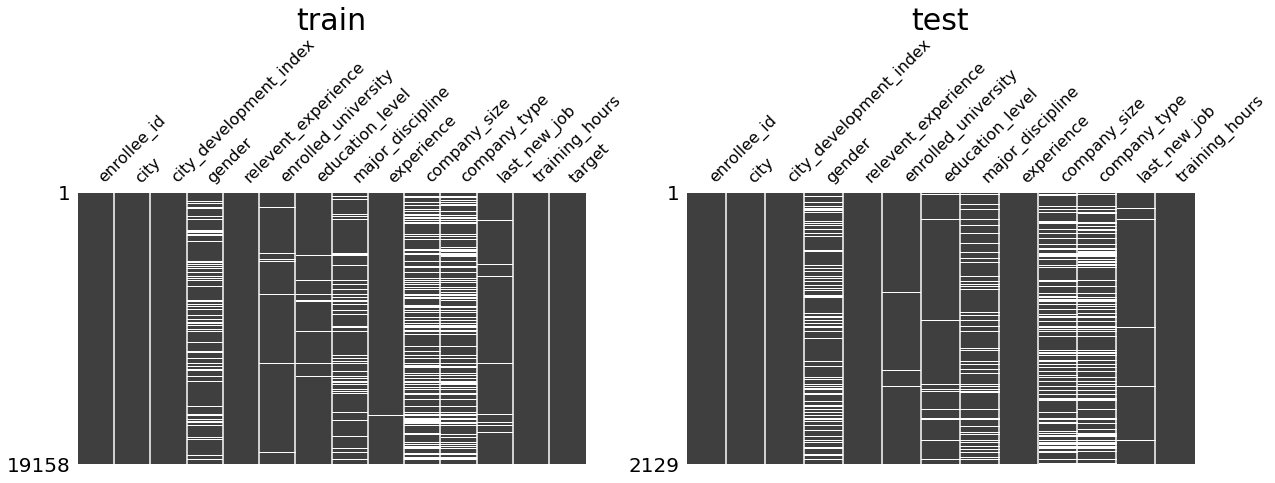

In [13]:
# null 값 확인

fig, ax = plt.subplots(ncols=2, nrows=1, figsize=(20,5))

msno.matrix(df=train.iloc[:, :],ax=ax[0])
msno.matrix(df=test.iloc[:, :],ax=ax[1])
ax[0].set_title("train",fontsize=30)
ax[1].set_title("test",fontsize=30)

plt.show()

### Handling Features (Labeling)

In [16]:
# NaN 처리먼저
# 그 후 라벨링
# 상관분석 및 변수시각화

In [3]:
# https://stackoverflow.com/questions/24458645/label-encoding-across-multiple-columns-in-scikit-learn
from sklearn.preprocessing import LabelEncoder

class MultiColumnLabelEncoder:
    def __init__(self,columns = None):
        self.columns = columns # array of column names to encode

    def fit(self,X,y=None):
        return self # not relevant here

    def transform(self,X):
        '''
        Transforms columns of X specified in self.columns using
        LabelEncoder(). If no columns specified, transforms all
        columns in X.
        '''
        output = X.copy()
        if self.columns is not None:
            for col in self.columns:
                # convert float NaN --> string NaN
                output[col] = output[col].fillna('NaN')
                output[col] = LabelEncoder().fit_transform(output[col])
        else:
            for colname,col in output.iteritems():
                output[colname] = LabelEncoder().fit_transform(col)
        return output

    def fit_transform(self,X,y=None):
        return self.fit(X,y).transform(X)



In [4]:
# store the catagorical features names as a list      
cat_features = train.select_dtypes(['object']).columns.to_list()
# use MultiColumnLabelEncoder to apply LabelEncoding on cat_features 
# uses NaN as a value , no imputation will be used for missing data
train_transform = MultiColumnLabelEncoder(columns = cat_features).fit_transform(train)
test_transform = MultiColumnLabelEncoder(columns = cat_features).fit_transform(test)

In [97]:
display(train)
display(train_transform)

,enrollee_id,city,city_development_index,gender,relevent_experience,enrolled_university,education_level,major_discipline,experience,company_size,company_type,last_new_job,training_hours,target
0,8949,city_103,0.920,Male,Has relevent experience,no_enrollment,Graduate,STEM,>20,NaN,NaN,1,36,1.0
1,29725,city_40,0.776,Male,No relevent experience,no_enrollment,Graduate,STEM,15,50-99,Pvt Ltd,>4,47,0.0
2,11561,city_21,0.624,NaN,No relevent experience,Full time course,Graduate,STEM,5,NaN,NaN,never,83,0.0
3,33241,city_115,0.789,NaN,No relevent experience,NaN,Graduate,Business,<1,NaN,Pvt Ltd,never,52,1.0
4,666,city_162,0.767,Male,Has relevent experience,no_enrollment,Masters,STEM,>20,50-99,Funded Startup,4,8,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19153,7386,city_173,0.878,Male,No relevent experience,no_enrollment,Graduate,Humanities,14,NaN,NaN,1,42,1.0
19154,31398,city_103,0.920,Male,Has relevent experience,no_enrollment,Graduate,STEM,14,NaN,NaN,4,52,1.0
19155,24576,city_103,0.920,Male,Has relevent experience,no_enrollment,Graduate,STEM,>20,50-99,Pvt Ltd,4,44,0.0
19156,5756,city_65,0.802,Male,Has relevent experience,no_enrollment,High School,NaN,<1,500-999,Pvt Ltd,2,97,0.0


,enrollee_id,city,city_development_index,gender,relevent_experience,enrolled_university,education_level,major_discipline,experience,company_size,company_type,last_new_job,training_hours,target
0,8949,5,0.920,1,0,3,0,6,21,8,3,0,36,1.0
1,29725,77,0.776,1,1,3,0,6,6,4,6,4,47,0.0
2,11561,64,0.624,2,1,0,0,6,15,8,3,6,83,0.0
3,33241,14,0.789,2,1,1,0,1,20,8,6,6,52,1.0
4,666,50,0.767,1,0,3,2,6,21,4,1,3,8,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19153,7386,55,0.878,1,1,3,0,2,5,8,3,0,42,1.0
19154,31398,5,0.920,1,0,3,0,6,5,8,3,3,52,1.0
19155,24576,5,0.920,1,0,3,0,6,21,4,6,3,44,0.0
19156,5756,94,0.802,1,0,3,1,3,20,5,6,1,97,0.0


In [99]:
display(test)
display(test_transform)

,enrollee_id,city,city_development_index,gender,relevent_experience,enrolled_university,education_level,major_discipline,experience,company_size,company_type,last_new_job,training_hours
0,32403,city_41,0.827,Male,Has relevent experience,Full time course,Graduate,STEM,9,<10,NaN,1,21
1,9858,city_103,0.920,Female,Has relevent experience,no_enrollment,Graduate,STEM,5,NaN,Pvt Ltd,1,98
2,31806,city_21,0.624,Male,No relevent experience,no_enrollment,High School,NaN,<1,NaN,Pvt Ltd,never,15
3,27385,city_13,0.827,Male,Has relevent experience,no_enrollment,Masters,STEM,11,10/49,Pvt Ltd,1,39
4,27724,city_103,0.920,Male,Has relevent experience,no_enrollment,Graduate,STEM,>20,10000+,Pvt Ltd,>4,72
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2124,1289,city_103,0.920,Male,No relevent experience,no_enrollment,Graduate,Humanities,16,NaN,Public Sector,4,15
2125,195,city_136,0.897,Male,Has relevent experience,no_enrollment,Masters,STEM,18,NaN,NaN,2,30
2126,31762,city_100,0.887,Male,No relevent experience,no_enrollment,Primary School,NaN,3,NaN,Pvt Ltd,never,18
2127,7873,city_102,0.804,Male,Has relevent experience,Full time course,High School,NaN,7,100-500,Public Sector,1,84


,enrollee_id,city,city_development_index,gender,relevent_experience,enrolled_university,education_level,major_discipline,experience,company_size,company_type,last_new_job,training_hours
0,32403,69,0.827,1,0,0,0,6,19,7,3,0,21
1,9858,5,0.920,0,0,3,0,6,15,8,6,0,98
2,31806,55,0.624,1,1,3,1,3,20,8,6,6,15
3,27385,22,0.827,1,0,3,2,6,2,0,6,0,39
4,27724,5,0.920,1,0,3,0,6,21,3,6,4,72
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2124,1289,5,0.920,1,1,3,0,2,7,8,5,3,15
2125,195,25,0.897,1,0,3,2,6,9,8,3,1,30
2126,31762,2,0.887,1,1,3,5,3,13,8,6,6,18
2127,7873,4,0.804,1,0,0,1,3,17,1,5,0,84


## Train-test split ( train dataset)


In [5]:
x = train_transform.iloc[:,1:13]
y = train_transform.iloc[:,13]
train_x, val_x , train_y, val_y = train_test_split(x, y, test_size=0.3, random_state=123, stratify=y )

# Modeling

### Modeling1 - Random Forest

In [22]:
rfc = RandomForestClassifier()
model_rfc = rfc.fit(train_x,train_y)

### Modeling2 - LightGBMClassifier using GridSearch

In [9]:
lgbm= LGBMClassifier()
model = lgbm.fit(train_x, train_y)
param_grid = {
 'learning_rate': [0.01, 0.1, 0.05, 0.5, 1],
    'n_estimators': [20, 40, 60, 80, 100, 120]
}
grid = GridSearchCV(estimator=lgbm, scoring='roc_auc',param_grid=param_grid, cv=5)

grid.fit(train_x, train_y)
print('best score=',grid.best_score_)
print('best parameter=',grid.best_params_)

best score= 0.7951933912867897
best parameter= {'learning_rate': 0.1, 'n_estimators': 40}


In [33]:
lgbm= LGBMClassifier(learning_rate=0.1, n_estimators= 40)
model_lgbm = lgbm.fit(train_x, train_y)

### Modeling3 - CatBoostClassifier using GridSearch

In [12]:
model_CBC = CatBoostClassifier()
 
parameters = {'depth'         : [6,8,10],
              'learning_rate' : [0.01, 0.05, 0.1],
             'iterations'    : [30, 50, 100]
                 }
grid = GridSearchCV(estimator=model_CBC, param_grid = parameters, cv = 2, n_jobs=-1)
grid.fit(train_x, train_y)
best_param = grid.best_estimator_

print("best score : ", grid.best_score_)
print("best parameters : ", grid.best_params_)

0:	learn: 0.6547532	total: 102ms	remaining: 10.1s
1:	learn: 0.6242574	total: 110ms	remaining: 5.38s
2:	learn: 0.5976573	total: 118ms	remaining: 3.82s
3:	learn: 0.5752801	total: 122ms	remaining: 2.93s
4:	learn: 0.5571417	total: 126ms	remaining: 2.39s
5:	learn: 0.5411555	total: 134ms	remaining: 2.1s
6:	learn: 0.5277932	total: 141ms	remaining: 1.87s
7:	learn: 0.5157929	total: 148ms	remaining: 1.71s
8:	learn: 0.5055000	total: 156ms	remaining: 1.57s
9:	learn: 0.4962714	total: 163ms	remaining: 1.47s
10:	learn: 0.4882693	total: 171ms	remaining: 1.38s
11:	learn: 0.4817429	total: 178ms	remaining: 1.3s
12:	learn: 0.4753816	total: 185ms	remaining: 1.24s
13:	learn: 0.4704842	total: 192ms	remaining: 1.18s
14:	learn: 0.4656636	total: 200ms	remaining: 1.13s
15:	learn: 0.4618717	total: 207ms	remaining: 1.09s
16:	learn: 0.4578642	total: 215ms	remaining: 1.05s
17:	learn: 0.4545142	total: 222ms	remaining: 1.01s
18:	learn: 0.4515253	total: 229ms	remaining: 977ms
19:	learn: 0.4491292	total: 239ms	remaining

In [13]:
cat = CatBoostClassifier(depth= 8, iterations= 100, learning_rate= 0.1)
model_cat = cat.fit(train_x, train_y)

0:	learn: 0.6547532	total: 15.4ms	remaining: 1.52s
1:	learn: 0.6242574	total: 23.9ms	remaining: 1.17s
2:	learn: 0.5976573	total: 30.9ms	remaining: 1s
3:	learn: 0.5752801	total: 38.3ms	remaining: 918ms
4:	learn: 0.5571417	total: 42.7ms	remaining: 811ms
5:	learn: 0.5411555	total: 51.1ms	remaining: 801ms
6:	learn: 0.5277932	total: 58.8ms	remaining: 781ms
7:	learn: 0.5157929	total: 69.8ms	remaining: 803ms
8:	learn: 0.5055000	total: 77.5ms	remaining: 783ms
9:	learn: 0.4962714	total: 87.9ms	remaining: 791ms
10:	learn: 0.4882693	total: 97.3ms	remaining: 787ms
11:	learn: 0.4817429	total: 107ms	remaining: 785ms
12:	learn: 0.4753816	total: 115ms	remaining: 770ms
13:	learn: 0.4704842	total: 125ms	remaining: 765ms
14:	learn: 0.4656636	total: 135ms	remaining: 764ms
15:	learn: 0.4618717	total: 143ms	remaining: 753ms
16:	learn: 0.4578642	total: 153ms	remaining: 749ms
17:	learn: 0.4545142	total: 163ms	remaining: 741ms
18:	learn: 0.4515253	total: 172ms	remaining: 734ms
19:	learn: 0.4491292	total: 180ms

### Models evaluation

In [29]:
rfc_y_pred = model_rfc.predict(val_x)
acc_rfc = accuracy_score(val_y,rfc_y_pred)

lgbm_y_pred = model_lgbm.predict(val_x)
acc_lgbm = accuracy_score(val_y,lgbm_y_pred)


catc_y_pred = model_cat.predict(val_x)
acc_catc = accuracy_score(val_y,catc_y_pred)

print("="*15, "Models Accuravy","="*15)
print("Random Forest : ",acc_rfc)
print("LightGBM : ",acc_lgbm)
print("CatBoostClassifier : ",acc_catc)


=============== Models Accuravy ===============
Random Forest :  0.7868823938761308
LightGBM :  0.8060194850382741
CatBoostClassifier :  0.7999304105775922


In [31]:
fpr_rfc, tpr_rfc, thresholds_rfc = roc_curve(val_y, rfc_y_pred)
auc_rfc = auc(fpr_rfc, tpr_rfc)

fpr_lgbm, tpr_lgbm, thresholds_lgbm = roc_curve(val_y, lgbm_y_pred)
auc_lgbm = auc(fpr_lgbm, tpr_lgbm)

fpr_catc, tpr_catc, thresholds_catc = roc_curve(val_y, catc_y_pred)
auc_catc = auc(fpr_catc, tpr_catc)

print("="*15, "Models AUC","="*15)
print("Random Forest : ",auc_rfc)
print("LightGBM : ",auc_lgbm)
print("CatBoostClassifier : ",auc_catc)


=============== Models AUC ===============
Random Forest :  0.6795419830044822
LightGBM :  0.7465873520937931
CatBoostClassifier :  0.7152656429032919


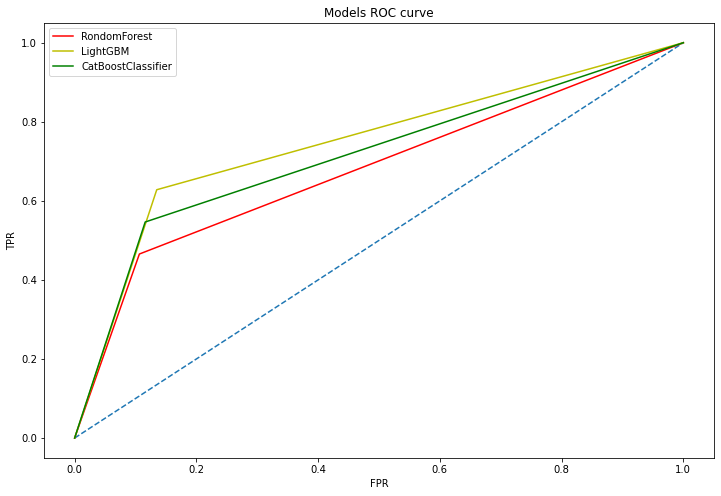

In [32]:
fig = plt.figure(figsize = (12, 8))
chart = fig.add_subplot(1,1,1)

plt.plot([0, 1], [0, 1], linestyle='--')
plt.plot(fpr_rfc, tpr_rfc,'r', label = 'RondomForest')
plt.plot(fpr_lgbm, tpr_lgbm,'y', label = 'LightGBM')
plt.plot(fpr_catc, tpr_catc,'g', label = 'CatBoostClassifier')


chart.set_title('Models ROC curve')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.legend(loc='best')

# Suggestion

In [46]:
su_test = test_transform.drop(['enrollee_id'],axis=1)

In [50]:
y_predict = model_lgbm.predict(su_test)
suggestion = pd.DataFrame({'enrollee_id' : test_transform['enrollee_id'],'target':y_predict})
suggestion = suggestion.sort_values(by='target' ,ascending=False)

In [53]:
suggestion

,enrollee_id,target
1236,12570,1.0
1778,27297,1.0
971,9163,1.0
504,23986,1.0
1771,5236,1.0
...,...,...
835,33112,0.0
832,29537,0.0
831,20431,0.0
830,2926,0.0


# Review

- 개인적으로 결론만 보면 분류모델보다는 확률로 나타낼 수 있는 회귀모델이 적합하다고 생각한다.
이 데이터의 경우, 종속변수가 Binary의 형태이기때문에 분류모델로 모델링을 해주어야 정확도가 그나마 80%가까이 나올 수 있다.
중간에 시간을 투자하여 catboost 를 이용하여 regression 모델을 적용해보았으나 정확도가 24%정도여서 모델을 사용할 수 없었다.
regression 모델을 사용하고 싶었던 이유는, 확률에 따라서 결과를 표현하는게 적합하다고 생각해서였다.
binary인경우 회귀모델은 쓸 수는 없는지, 또한 사용하기 위해서 어떤 처리과정을 추가해주어야하는지 추후에 시간이 있으면 다시 시도해보려고 한다.

- 모델링을 세개를 적용해주면서, 생각보다 모델 정확도가 낮아서 그 이유는 무엇인지 찾아보았다. 
아마 overfitting이 문제였던 것 같아서. k_fold cross validation을 이용하였다. 하지만 그렇다고 하여 정확성이 크게 차이가 나지는 않았다. 다른 캐글러의 글들을 보며 조금씩 더 공부를 해야할 것 같다. 

- Null값을 다루기 위해 3개의 imputor를 사용하였다. 그 중  MI적용시킨 labelencoding 을 이용하였다.(stackflow 참조) 본 노트북에는 없지만, 다른 두개의 imputor는 knn과 bayesian 을 이용하였으나,  Knn은 데이터적중률이 낮아지는 듯하고 baysian은 시간관계상 공부할 시간이 없어서 적용하다가 미뤄뒀다. 

- 모델들의 검증방법을 자세히 알고 적용할 수 있었던 좋은 데이터였다.



### self  assignment

- Bayesian Imputor 
- Why decrease accuracy?
- How come increse model's accuracy?